# **Создание окружения для работы ImageJ в Google Colab**
---
⛔ **Опасная зона!**
<br>Пожалуйста, не изменяйте и не переносити фрагменты кода из этого раздела.

In [1]:
# установка JDK8 в Google Colab
import os
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null    # установка openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    # настройка окружения
    !java -version
!apt update install_java()

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `apt update install_java()'


In [2]:
# установка Maven в Google Colab
!sudo apt-get install maven

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libaopalliance-java libapache-pom-java libatinject-jsr330-api-java
  libcdi-api-java libcommons-cli-java libcommons-io-java libcommons-lang3-java
  libcommons-parent-java libgeronimo-annotation-1.3-spec-java
  libgeronimo-interceptor-3.0-spec-java libguava-java libguice-java
  libhawtjni-runtime-java libjansi-java libjansi-native-java libjsr305-java
  libmaven-parent-java libmaven-resolver-java libmaven-shared-utils-java
  libmaven3-core-java libplexus-cipher-java libplexus-classworlds-java
  libplexus-component-annotations-java libplexus-interpolation-java
  libplexus-sec-dispatcher-java libplexus-utils2-java libsisu-inject-java
  libsisu-plexus-java libslf4j-java libwagon-file-java
  libwagon-http-shaded-java libwagon-provider-api-java
Suggested packages:
  libaopalliance-java-doc libatinject-jsr330-api-java-doc libservlet3.1-java
  li

In [3]:
# установка PyImageJ в Google Colab
!pip install Cython pyimagej

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 18.8 MB/s eta 0:00:00


In [4]:
# установка PyJnius в Google Colab
!wget https://anaconda.org/conda-forge/pyjnius/1.2.0/download/osx-64/pyjnius-1.2.0-py37h90b5fae_0.tar.bz2 && tar -xjf pyjnius-1.2.0-py37h90b5fae_0.tar.bz2 -C /usr/local
# настройка рабочей среды 
os.environ["PYJNIUS_JAR"] = "/usr/local/share/pyjnius/pyjnius.jar"

--2023-03-09 09:25:24--  https://anaconda.org/conda-forge/pyjnius/1.2.0/download/osx-64/pyjnius-1.2.0-py37h90b5fae_0.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5b5200910219ba13273541e3/5c6004c0d9c2cf34c4d1625c?response-content-disposition=attachment%3B%20filename%3D%22pyjnius-1.2.0-py37h90b5fae_0.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27pyjnius-1.2.0-py37h90b5fae_0.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=600&X-Amz-Date=20230309T092524Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEKD%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJGMEQCIFQISKOFQVAM8T8%2FrhaP77A3qLLhBz31Q5vgSwZB50jXAiAwcp9A2bHjscmsT8nYHXUbiRGt1%2FOIhtrLTcBM5KhhFSqzBQhYEAAaDDQ1NTg2NDA5ODM3OCIMZxp%2FBID%2FeBXW

In [5]:
# запуск PyImageJ с плагинами Fiji версии 2.9.0/1.53t
import imagej
ij = imagej.init('sc.fiji:fiji:2.9.0')
print(ij.getVersion())

2.9.0/1.53t


In [19]:
# при возникновении проблем с версией 2.9.0/1.53t доступен вызов imagej.init('sc.fiji:fiji'), однако в таком случае не гарантируется работоспособность сценария исполнения команд ImageJ2

# **Автоматизированный анализ изображений средствами PyImageJ**

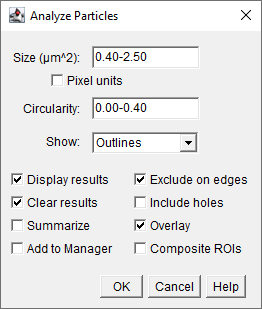

Параметры, используемые при бинаризации изображения:
*   метод установки порога - Triangle (method=Triangle)
*   цвет фона - светлый (background=Light)

Параметры, используемые при анализе частиц:
*   размер 0.40-2.50 мкм.^2 (size=0.40-2.50)
*   округлость 0.00-0.40 (circularity=0.00-0.40)

Оцениваемые характеристики:
*   площадь, мкм.^2 (area)
*   форма = округлость (citcularity)
*   диаметр Фере, мкм. (feret)
*   прочие измерения, связанные с вычислением даиметра Фере, не рассматриваются







In [15]:
from scyjava import jimport

# сценарий исполнения ImageJ2 команд обработки изображения
imp = ij.IJ.openImage("/content/gmax-2490-28-15-12-2.lsm");
ij.py.run_plugin(plugin="Set Measurements...", args="area shape feret's stack redirect=None decimal=3");
ij.py.run_plugin(imp=imp, plugin="8-bit", args="");
ij.IJ.setAutoThreshold(imp, "Default dark");
ij.py.run_plugin(imp=imp, plugin="Convert to Mask", args="method=Triangle background=Light calculate");
ij.py.run_plugin(imp=imp, plugin="Analyze Particles...", args="size=0.40-2.50 circularity=0.00-0.40 show=Outlines display exclude clear overlay stack");
ij.IJ.saveAs('Results', "/content/Results.csv");

[java.lang.Enum.toString]  	Area	Circ.	Feret	Slice	FeretX	FeretY	FeretAngle	MinFeret	AR	Round	Solidity[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	0.478	0.317	1.400	2	1221	16	65.225	0.658	2.474	0.404	0.649[java.lang.Enum.toString] 
[java.lang.Enum.toString] 2	0.478	0.138	1.688	2	639	8	169.992	0.587	2.329	0.429	0.588[java.lang.Enum.toString] 
[java.lang.Enum.toString] 3	2.152	0.193	3.217	2	108	12	160.463	1.329	2.724	0.367	0.636[java.lang.Enum.toString] 
[java.lang.Enum.toString] 4	0.669	0.218	1.785	2	562	16	170.538	0.880	1.902	0.526	0.603[java.lang.Enum.toString] 
[java.lang.Enum.toString] 5	1.042	0.206	2.948	2	1316	22	95.711	0.705	6.237	0.160	0.572[java.lang.Enum.toString] 
[java.lang.Enum.toString] 6	0.583	0.300	1.881	2	1212	46	81.027	0.489	4.574	0.219	0.744[java.lang.Enum.toString] 
[java.lang.Enum.toString] 7	2.142	0.238	2.476	2	30	32	170.910	1.467	1.588	0.630	0.730[java.lang.Enum.toString] 
[java.lang.Enum.toString] 8	1.272	0.367	2.324	2	86	29	112.249	0.955	2.580	0.388	0.

# **Статистическая обработка результатов морфометрического анализа**

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.notebook import tqdm

Введите в поле ниже название анализируемого образца

In [11]:
sample_name = "gmax-2490-28-15-12-2"

In [16]:
# предобработка данных и очистка выбросов
data_bacteria = pd.read_csv("/content/Results.csv", index_col=0)
slice = data_bacteria.Slice.unique()

for i in slice:
    if i%2!=0:
        data_bacteria = data_bacteria.query('Slice != @i')      

names = ['Feret', 'Area']
for name in names:
    Q1 = data_bacteria[name].quantile(0.25)
    Q3 = data_bacteria[name].quantile(0.75)
    IQR = Q3 - Q1
    Floor = Q1 - IQR * 1.5
    Top = Q3 + IQR * 1.5
    data_bacteria = data_bacteria[data_bacteria[name] >= Floor]
    data_bacteria = data_bacteria[data_bacteria[name] <= Top]
    
display(data_bacteria[['Feret','Area']].describe())

,Feret,Area
count,723.000000,723.000000
mean,2.124072,0.758411
std,0.401958,0.258966
min,1.140000,0.402000
25%,1.845000,0.555000
50%,2.093000,0.708000
75%,2.397000,0.899000
max,3.372000,1.578000


In [17]:
# сохраняем датафрейм с очищенными данными
output_name = 'Results_' + sample_name + '.csv'
data_bacteria.reset_index(drop=True).to_csv(output_name)

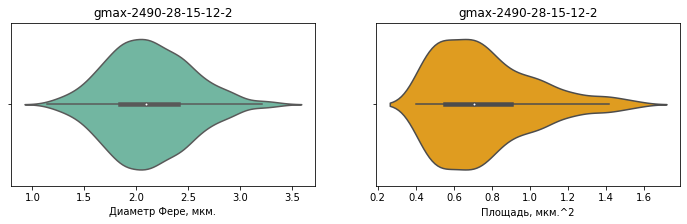

In [18]:
# визуализация диаметра Фере и площади клеток
plt.figure(figsize=(12, 3))

ax1 = plt.subplot(1, 2, 1)
sns.violinplot(data=data_bacteria, x='Feret', palette='Set2')
plt.title(sample_name)
plt.xlabel('Диаметр Фере, мкм.')
plt.grid(False)

ax2 = plt.subplot(1, 2, 2)
sns.violinplot(data=data_bacteria, x='Area', color='Orange')
plt.title(sample_name)
plt.xlabel('Площадь, мкм.^2')
plt.grid(False);